let's  first install dependecies in our notebook

In [1]:
!pip install keras-nlp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.0/572.0 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 76.7 MB/s eta 0:00:00


**Load and prepare the data**


In [2]:
! unzip /content/fra-eng.zip -d /content/fra-eng

Archive:  /content/fra-eng.zip
  inflating: /content/fra-eng/_about.txt  
  inflating: /content/fra-eng/fra.txt  


In [3]:
import pandas as pd
df = pd.read_csv('/content/fra-eng/fra.txt', names=['en', 'fr', 'attr'],
usecols=['en', 'fr'], sep='\t')
df = df.sample(frac=1, random_state=42)
df = df.reset_index(drop=True)
df.head()

,en,fr
0,Are you envious?,Êtes-vous jalouse ?
1,All I want you to do is talk to us.,Tout ce que je veux que tu fasses est de nous ...
2,You're a good student.,Vous êtes un bon étudiant.
3,Can you swim at all?,Sais-tu au moins nager ?
4,He's curious about everything.,Il est curieux de tout.


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232736 entries, 0 to 232735
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   en      232736 non-null  object
 1   fr      232736 non-null  object
dtypes: object(2)
memory usage: 3.6+ MB


Clean the text by removing punctuation symbols and numbers, converting characters to lowercase, and replacing Unicode characters with their ASCII equivalents. For the French samples, insert [start] and [end] tokens at the beginning and end of each phrase.

In [5]:
import re
from unicodedata import normalize

def clean_text(text):
  text = normalize('NFD', text.lower())
  text = re.sub('[^A-Za-z ]+', '', text)
  return text

def clean_and_prepare_text(text):
  text='[start] ' + clean_text(text) + '[end]'
  return text

df['en'] = df['en'].apply(lambda row : clean_text(row))
df['fr'] = df['fr'].apply(lambda row : clean_and_prepare_text(row))
df.head()

,en,fr
0,are you envious,[start] etesvous jalouse [end]
1,all i want you to do is talk to us,[start] tout ce que je veux que tu fasses est ...
2,youre a good student,[start] vous etes un bon etudiant[end]
3,can you swim at all,[start] saistu au moins nager[end]
4,hes curious about everything,[start] il est curieux de tout[end]


The next step is to scan the phrases and determine the maximum length of the English phrases and then of the French phrases. These lengths will determine the lengths of the sequences input to and output from the model:

In [6]:
en = df['en']
fr = df['fr']
en_max_len = max(len(line.split()) for line in en)
fr_max_len = max(len(line.split()) for line in fr)
sequence_len = max(en_max_len, fr_max_len)

print(f'Max phrase length (English): {en_max_len}')
print(f'Max phrase length (French): {fr_max_len}')
print(f'Sequence length: {sequence_len}')

Max phrase length (English): 55
Max phrase length (French): 57
Sequence length: 57


In [7]:
def find_longest_phrase(df, column):
    max_len = max(len(line.split()) for line in df[column])
    longest_phrases = [line for line in df[column] if len(line.split()) == max_len]
    return longest_phrases

longest_en_phrases = find_longest_phrase(df, 'en')
longest_fr_phrases = find_longest_phrase(df, 'fr')

print(f'Longest English phrases: {longest_en_phrases}')
print(f'Longest French phrases: {longest_fr_phrases}')

Longest English phrases: ['i went drinking with one of my boyfriends friends and now hes furious at me was this friend a guy or a girl a guy obviously why would i go drinking with his female friends yeah youre right his name is tom hes really hot and i really want to go drinking with him again']
Longest French phrases: ['[start] je suis allee boire avec un ami de mon compagnon et voila quil est furieux contre moi etaitce un gars ou une fille un gars bien evidemment pourquoi iraisje boire avec ses amies ouais ca se comprend il sappelle tom il est trop canon et jai tellement envie daller prendre un verre avec lui a nouveau[end]']


Now fit one Tokenizer to the English phrases and another Tokenizer to their French equivalents, and generate padded sequences for all the phrases:

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
en_tokenizer = Tokenizer()
en_tokenizer.fit_on_texts(en)
en_sequences = en_tokenizer.texts_to_sequences(en)
en_x = pad_sequences(en_sequences, maxlen= sequence_len, padding='post')
fr_tokenizer =Tokenizer(filters='!"#$%&()*+,-./:;<=>?@\\^_`{|}~\t\n')
fr_tokenizer.fit_on_texts(fr)
fr_sequences = fr_tokenizer.texts_to_sequences(fr)
fr_y = pad_sequences(fr_sequences, maxlen=sequence_len +1, padding='post')

Compute the vocabulary sizes from the Tokenizer instances:

In [9]:
en_vocab_size = len(en_tokenizer.word_index) + 1
fr_vocab_size = len(fr_tokenizer.word_index) + 1
print(f'Vocabulary size (English): {en_vocab_size}')
print(f'Vocabulary size (French): {fr_vocab_size}')

Vocabulary size (English): 16656
Vocabulary size (French): 43032


Finally, create the features and the labels the model will be trained with. The features are the padded English sequences and the padded French sequences minus the [end] tokens. The labels are the padded French sequences minus the [start] tokens. Package the features in a dictionary so they can be input to a model that accepts multiple inputs.

In [10]:
inputs = { 'encoder_input': en_x, 'decoder_input': fr_y[:, :-1] }
outputs = fr_y[:, 1:]

**Build and train a model**

Now use Keras's functional API to define a model that includes a transformer encoder and a transformer decoder. The model accepts two inputs: padded English sequences for the encoder, and padded French sequences for the decoder. The output from the decoder is fed to a softmax output layer for classification.

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from keras_nlp.layers import TokenAndPositionEmbedding, TransformerEncoder
from keras_nlp.layers import TransformerDecoder

np.random.seed(42)
tf.random.set_seed(42)

num_heads = 8
embed_dim = 256

encoder_input = Input(shape=(None,), dtype='int64', name='encoder_input')
x = TokenAndPositionEmbedding(en_vocab_size, sequence_len, embed_dim)(encoder_input)
encoder_output = TransformerEncoder(embed_dim, num_heads)(x)
encoded_seq_input = Input(shape=(None, embed_dim))

decoder_input = Input(shape=(None,), dtype='int64', name='decoder_input')
x = TokenAndPositionEmbedding(fr_vocab_size, sequence_len, embed_dim, mask_zero=True)(decoder_input)
x = TransformerDecoder(embed_dim, num_heads)(x, encoded_seq_input)
x = Dropout(0.4)(x)

decoder_output = Dense(fr_vocab_size, activation='softmax')(x)
decoder = Model([decoder_input, encoded_seq_input], decoder_output)
decoder_output = decoder([decoder_input, encoder_output])

model = Model([encoder_input, decoder_input], decoder_output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary(line_length=120)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ encoder_input (InputLayer)        │ (None, None)                 │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ token_and_position_embedding      │ (None, None, 256)            │         4,278,528 │ encoder_input[0][0]       
│ (TokenAndPositionEmbedding)       │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ decoder_input (InputLayer)        │ (None, None)                 │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ transformer_encoder               │ (None, None, 256)            │           395,776 │ token_and_position_embeddi
│ (TransformerEncoder)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ functional (Functional)           │ (None, None, 43032)          │        22,749,464 │ decoder_input[0][0],      
│                                   │                              │                   │ transformer_encoder[0][0] 
└───────────────────────────────────┴──────────────────────────────┴───────────────────┴───────────────────────────

 Total params: 27,423,768 (104.61 MB)

 Trainable params: 27,423,768 (104.61 MB)

 Non-trainable params: 0 (0.00 B)

Train the model, and use an EarlyStopping callback to end training if the validation accuracy fails to improve for three consecutive epochs:

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
hist = model.fit(inputs, outputs, epochs=50, validation_split=0.2, callbacks=[callback])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'position_embedding' (of type PositionEmbedding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.

5819/5819 ━━━━━━━━━━━━━━━━━━━━ 387s 64ms/step - accuracy: 0.4885 - loss: 4.9235 - val_accuracy: 0.4569 - val_loss: 1.5286
Epoch 2/50
5819/5819 ━━━━━━━━━━━━━━━━━━━━ 362s 62ms/step - accuracy: 0.5352 - loss: 1.3020 - val_accuracy: 0.6580 - val_loss: 0.8702
Epoch 3/50
5819/5819 ━━━━━━━━━━━━━━━━━━━━ 375s 61ms/step - accuracy: 0.6671 - loss: 0.7537 - val_accuracy: 0.7159 - val_loss: 0.7532
Epoch 4/50
5819/5819 ━━━━━━━━━━━━━━━━━━━━ 358s 61ms/step - accuracy: 0.6681 - loss: 0.5867 - val_accuracy: 0.7053 - val_loss: 0.7044
Epoch 5/50
5819/5819 ━━━━━━━━━━━━━━━━━━━━ 378s 61ms/step - accuracy: 0.6693 - loss: 0.4555 - val_accuracy: 0.6422 - val_loss: 0.6839
Epoch 6/50
5819/5819 ━━━━━━━━━━━━━━━━━━━━ 366s 58ms/step - accuracy: 0.6662 - loss: 0.3722 - val_accuracy: 0.7240 - val_loss: 0.6359
Epoch 7/50
5819/5819 ━━━━━━━━━━━━━━━━━━━━ 393s 60ms/step - accuracy: 0.6345 - loss: 0.3648 - val_accuracy: 0.6259 - val_loss: 0.6553
Epoch 8/50
5819/5819 ━━━━━━━━━━━━━━━━━━━━ 370s 58ms/step - accuracy: 0.6310 - lo

Plot the training and validation accuracy:

[]

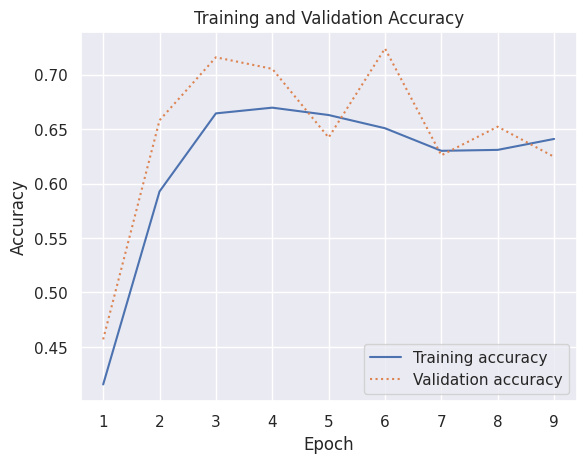

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

**Use the model to translate text**

Can the model really translate English to French? Let's use a subset of the phrases reserved to validate the model to make predictions and see .

In [ ]:
def translate_text(text, model, en_tokenizer, fr_tokenizer, fr_index_lookup, sequence_len):
    input_sequence = en_tokenizer.texts_to_sequences([text])
    padded_input_sequence = pad_sequences(input_sequence, maxlen=sequence_len, padding='post')
    decoded_text = '[start]'

    for i in range(sequence_len):
        target_sequence = fr_tokenizer.texts_to_sequences([decoded_text])
        padded_target_sequence = pad_sequences(target_sequence, maxlen=sequence_len, padding='post')[:, :-1]

        prediction = model([padded_input_sequence, padded_target_sequence])

        idx = np.argmax(prediction[0, i, :]) - 1
        token = fr_index_lookup[idx]
        decoded_text += ' ' + token

        if token == '[end]':
            break

    return decoded_text[8:-6] # Remove [start] and [end] tokens

fr_vocab = fr_tokenizer.word_index
fr_index_lookup = dict(zip(range(len(fr_vocab)), fr_vocab))
texts = en[40000:40010].values

for text in texts:
    translated = translate_text(text, model, en_tokenizer, fr_tokenizer, fr_index_lookup, sequence_len)
    print(f'{text} => {translated}')

Finally,let's see how the model translates "I am a translator" into French:

---



In [ ]:
translate_text('I am a translator', model, en_tokenizer, fr_tokenizer, fr_index_lookup, sequence_len)